### 정형데이터 공기오염 데이터셋

In [1]:
import pandas as pd

df = pd.read_csv('c:/workspace3/data/pollution.csv', index_col=0)
df

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [2]:
df.columns

Index(['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow',
       'rain'],
      dtype='object')

<Axes: >

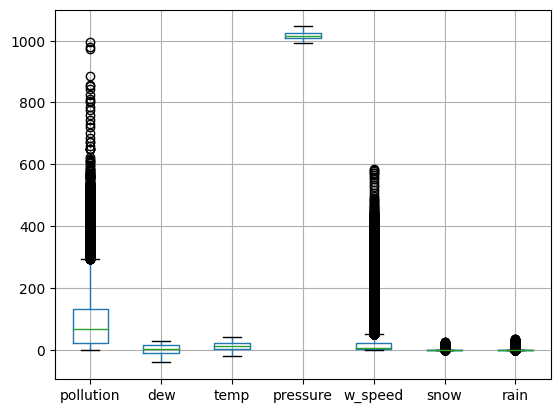

In [3]:
df.boxplot()

In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

values = df.values

encoder = LabelEncoder()

# w_dr 변수 정수인코딩
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
np.unique(values[:,4])

array([0., 1., 2., 3.], dtype=float32)

In [5]:
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

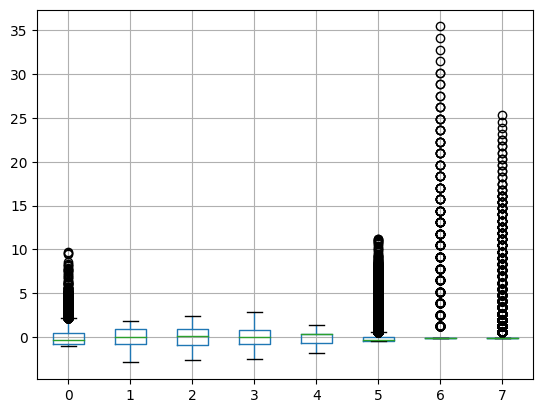

In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).boxplot()

plt.show()

In [7]:
real_data=scaled

In [8]:
# 모델 파라미터 설정

d_input=real_data.shape[1] #변수의 개수

d_hidden = 32
d_output = 1
g_input = 32
g_hidden = 32

g_output = d_input

In [9]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import numpy as np

# fake data 생성
def makeZ(m, n):
    z = np.random.uniform(-1.0, 1.0, size=[m, n])

    return z

def myOptimizer(lr):

    return RMSprop(learning_rate=lr)

# 판별 모델
def build_D():
    d_x = Input(batch_shape=(None, d_input))
    d_h = Dense(d_hidden, activation='relu')(d_x)
    d_o = Dense(d_output, activation='sigmoid')(d_h)

    d_model = Model(d_x, d_o)
    d_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.01))

    return d_model

In [10]:
from tensorflow.keras import backend as K

K.clear_session()

D = build_D()

In [11]:
D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 생성 모델

def build_G():
    g_x = Input(batch_shape=(None, g_input))    
    g_h = Dense(g_hidden, activation='relu')(g_x)
    g_o = Dense(g_output, activation='linear')(g_h)

    g_model = Model(g_x, g_o)

    return g_model

# GAN 모델
def build_GAN(discriminator, generator):
    discriminator.trainable = False

    z = Input(batch_shape=(None, g_input))
    Gz = generator(z)
#           가짜
    DGz = discriminator(Gz)
#              판별

    gan_model = Model(z, DGz)
    gan_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.01))

    return gan_model

In [13]:
G = build_G()

In [14]:
G.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [18]:
GAN = build_GAN(D, G)

In [19]:
GAN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 model_1 (Functional)        (None, 8)                 1320      
                                                                 
 model (Functional)          (None, 1)                 321       
                                                                 
Total params: 1,641
Trainable params: 1,320
Non-trainable params: 321
_________________________________________________________________


In [34]:
n_batch_cnt = 5
n_batch_size = int( real_data.shape[0] / n_batch_cnt)

EPOCHS = 250

for epoch in range(EPOCHS):
    X = real_data[:]
#                실제
    Z = makeZ(m=X.shape[0], n=g_input)
#                 가짜
    Gz = G.predict(Z) # 가짜 데이터로부터 분포 생성

    # discriminator 학습 데이터 준비
    d_target = np.zeros(X.shape[0]*2)
    d_target[:X.shape[0]] = 1   # 진짜 데이터
    d_target[X.shape[0]:] = 0   # 가짜 데이터

    bX_Gz = np.concatenate([X, Gz])    

    # generator 학습 데이터 준비
    g_target = np.zeros(Z.shape[0])
    g_target[:] = 1

    # discriminator 학습        
    loss_D = D.train_on_batch(bX_Gz, d_target) # loss 계산

    # generator 학습        
    loss_G = GAN.train_on_batch(Z, g_target)

    if epoch % 10 == 0:
        print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))

1369/1369 [==============================] - 2s 1ms/step
Epoch: 0, D-loss = 0.6242, G-loss = 0.8161
1369/1369 [==============================] - 1s 915us/step
Epoch: 10, D-loss = 0.6439, G-loss = 0.8446
1369/1369 [==============================] - 1s 1ms/step
Epoch: 20, D-loss = 0.6502, G-loss = 0.7999
1369/1369 [==============================] - 1s 1ms/step
Epoch: 30, D-loss = 0.6318, G-loss = 0.7923
1369/1369 [==============================] - 1s 1ms/step
Epoch: 40, D-loss = 0.6392, G-loss = 0.8147
1369/1369 [==============================] - 2s 1ms/step
Epoch: 50, D-loss = 0.6262, G-loss = 0.8153
1369/1369 [==============================] - 1s 968us/step
Epoch: 60, D-loss = 0.6310, G-loss = 0.8196
1369/1369 [==============================] - 1s 1ms/step
Epoch: 70, D-loss = 0.6430, G-loss = 0.8305
1369/1369 [==============================] - 1s 1ms/step
Epoch: 80, D-loss = 0.6286, G-loss = 0.8076
1369/1369 [==============================] - 1s 952us/step
Epoch: 90, D-loss = 0.6196, G

1369/1369 [==============================] - 2s 1ms/step


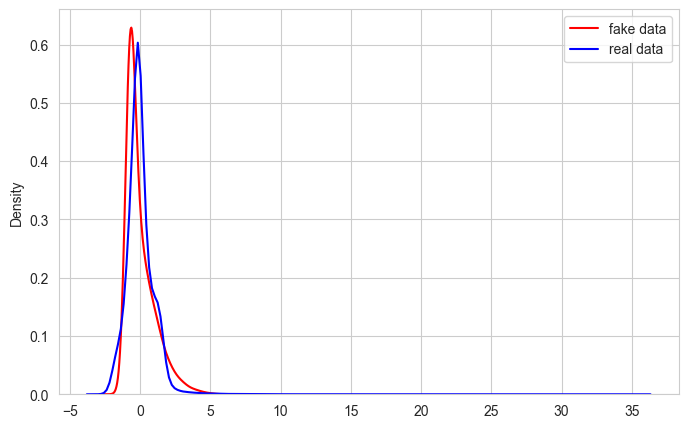

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 학습 완료 후 데이터 분포 시각화
z = makeZ(m=real_data.shape[0], n=g_input)
fake_data = G.predict(z)

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(fake_data[:, 0], color='red', bw_method=0.3, label='fake data')
sns.kdeplot(real_data.reshape(-1,1)[:, 0], color='blue', bw_method=0.3, label='real data')
plt.legend()

plt.show()

#실제 데이터와 분포가 매우 유사함

In [36]:
real = scaler.inverse_transform(real_data)
fake = scaler.inverse_transform(fake_data)

In [37]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(real[:,3], fake[:,3]))

15.503995

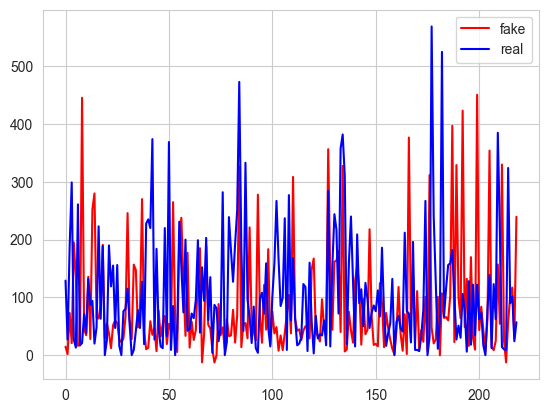

In [38]:
plt.plot(fake[::200,0], color='red', label='fake')
plt.plot(real[::200,0], color='blue', label='real')
plt.legend()

plt.show()

In [39]:
df2=pd.DataFrame(fake, columns=['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow','rain'])

df2.head()

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
0,14.626042,-4.926201,17.984051,1011.300354,0.249374,7.616221,0.023200,0.045061
1,19.678005,-9.759507,3.783913,1020.590820,0.878773,51.331562,0.000982,-0.015264
2,382.650421,22.510508,27.166069,1007.768860,1.964391,8.880092,0.016536,0.000390
3,106.988075,19.446423,23.736267,1006.285767,-0.494382,-0.892673,0.009328,-0.004096
4,43.298496,-28.342812,-12.119864,1032.799805,1.045579,9.296487,0.005575,-0.003164


In [40]:
df2.to_csv('c:/workspace3/data/pollution_gan.csv',index=False)